In [127]:
%load_ext autoreload
%autoreload 2
import healpy as hp
from spectral_index import find_spec_index
import numpy as np
import matplotlib.pyplot as plt
import h5py
import fgivenx
from scipy import stats
from astropy import units as u
import astropy
import copy
import os
from fgivenx import plot_contours, plot_lines, plot_dkl
from reconstruct_map import Reconstructor
import read_in_posterior_info as read


#extrapolate
def extrapolate_in_nu(map_in, nu_base, nu_desired, beta):
    map_in_copy = map_in.copy()
    return map_in_copy*(nu_desired/nu_base)**(-beta)

def apply_hp_mask(map_in, threshold):
    map_out = map_in.copy()
    for i in range(map_in.shape[0]):
        if map_in[i] == threshold:
            map_out[i] = hp.UNSEEN
    return map_out

#they both do the same thing
def apply_hp_mask(map_in, threshold):
    mask = np.where(map_in == threshold)
    map_out = map_in.copy()
    for i in range(len(mask[0])):
        map_out[mask[0][i]] = hp.UNSEEN
        
    return map_out


def replace_area_with_number(map_to_be_replaced, value, map_replacer):
#takes in a map, finds the masked regions and replaces it with the value found in another map
    map_to_be_replaced_copy = map_to_be_replaced.copy()
    map_replacer_copy = map_replacer.copy()
    regions_to_replace = np.where(map_to_be_replaced_copy == value)
    for i in range(len(regions_to_replace[0])):
        map_to_be_replaced_copy[regions_to_replace[0][i]] = map_replacer_copy[regions_to_replace[0][i]]

    return map_to_be_replaced_copy


def copy_masked_area_from_one_to_another(map_with_masks, map_to_be_masked):
#takes in a map, finds the masked regions and replaces it with the value found in another map
    map_with_masks_copy = map_with_masks.copy()
    map_to_be_masked_copy = map_to_be_masked.copy()
    regions_to_replace = np.where(map_with_masks_copy == hp.UNSEEN)
    for i in range(len(regions_to_replace[0])):
        map_to_be_masked_copy[regions_to_replace[0][i]] = hp.UNSEEN

    return map_to_be_masked_copy


def mean_unmasked_region(map_with_masks, mask_value):
    masked_regions = np.where(map_with_masks == mask_value)
    #make a copy
    map_with_masks_copy = map_with_masks.copy()
    try:
        n = 0
        for i in range(len(masked_regions[0])):
            map_with_masks_copy[masked_regions[0][i]] = 0
            n += 1
        return np.sum(map_with_masks_copy)/float(len(map_with_masks_copy ) - n)
    except:
        print('There are no masked regions')
        return np.mean(map_with_masks_copy)
            
            

def convert_ell_to_degrees(ell):
    return float(360)/float(2*ell)

def convert_ell_to_rads(ell):
    return float(2*np.pi)/float(2*ell)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mask generator

In [10]:
import PercentileMaskGenerator as PMG
#PMG.generate_masks ---> function name

### Load Relevant Maps

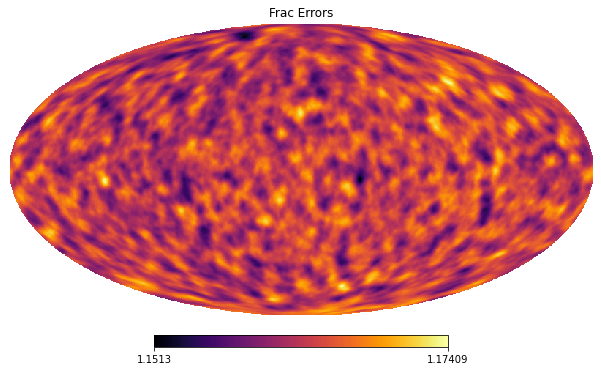

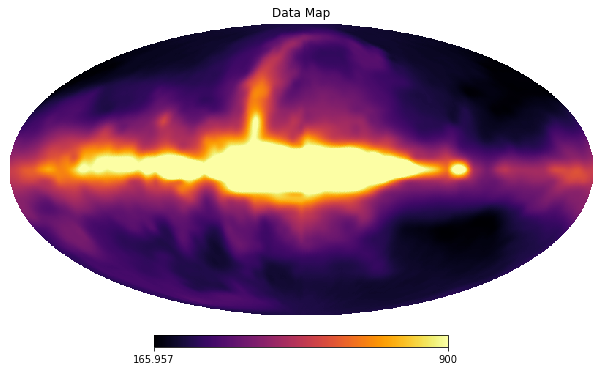

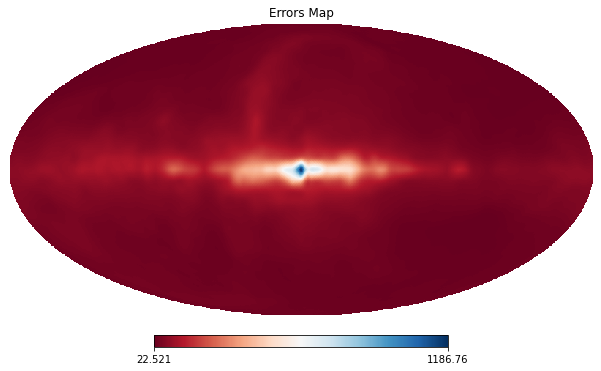

In [9]:
#Note that the prior range used for the scale factors of this analysis are tight 1.05 - 1.25
#we are also using the fractional errors as our prior map

path2maps = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/Maps'
error_map = np.load(os.path.join(path2maps, 'AngularPspecErrors_Scaledby150MHzBaseMapRayleighJeans_forAllySky150MHz.npy'))
basemap = np.load(os.path.join(path2maps,'allsky_150MHz.npy'))
datamap = np.load(os.path.join(path2maps, 'allsky_150MHz_wAngularPspecErrorsRayleighJeans_Scaledby150MHzBaseMap.npy'))
frac_errors = np.true_divide( np.add(error_map ,  basemap), basemap)


hp.visufunc.mollview(frac_errors ,  title = 'Frac Errors' , cmap = 'inferno')
hp.visufunc.mollview(datamap ,  title = 'Data Map' , cmap = 'inferno', max = 900)
hp.visufunc.mollview(error_map ,  title = 'Errors Map' , cmap = 'RdBu')




# Along horizontal axes

-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
Find a better way to do this please
-------------------

<ipython-input-121-b1abd56b8f0a>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  betas = np.array(betas)


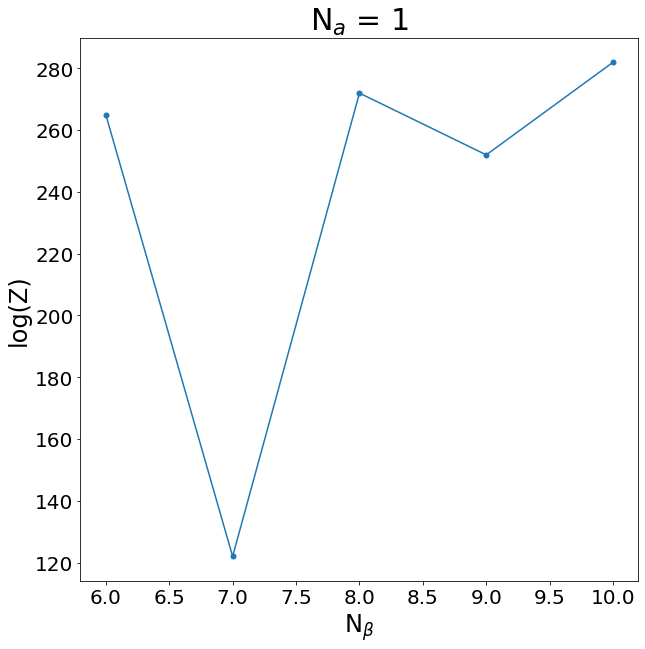

[[1.15912536]
 [1.16514165]
 [1.16461567]
 [1.16471838]
 [1.16531688]
 [1.16465275]
 [1.16507617]
 [1.16483678]
 [1.16480161]
 [1.1646731 ]]


In [121]:
#where to look for files 
path2files = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/AlongBetaAxis'
base_dir_name = '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_1_60MinObs_SpectralComplexity_N'

#how many directories do we need to run the loop for?
N_range = np.arange(10) + 1

#initialize arrays to store the relevant information
logZs = np.zeros_like(N_range)
scale_factors = []
betas  = []

base_dir_name = [base_dir_name +  str(total) for counter, total in enumerate(N_range)  ]


for ctr, beta_total in enumerate(N_range):
    f = open(os.path.join(path2files,base_dir_name[ctr] , 'test.stats'), 'r') 
    lines = f.read()
    
    #this needs to be changed every time we do this :(  
    N_reg_scafac = base_dir_name[ctr][78:79]
    

    r = lines.find('log(Z)       =')
    #print(lines[r+15:r + 39])
    logZs[ctr]  = float(lines[r+15:r + 40])
    
    scafacs = []
    sis = []
    #i = 0 corresponds to 1 dim
    print('-----------------------------Read in Betas and Scafacs -------------------------------------------------')
    for ctr_j , beta in enumerate(np.arange(beta_total) + 1):
        #which dim in test.stats are we reading?
        digit = str(beta).strip(".0")        
        r = lines.find(digit + '  0.')
        #print('file ', os.path.join(path2files,base_dir_name[ctr]),  'dim ' , float(lines[r + 3:r + 26]))
        sis.append(float(lines[r+ 3:r + 26]))
    betas.append(sis)
    
    #Read in scale factors, if any
    for ctr_i , scafac in enumerate(np.arange(int(N_reg_scafac) ) + beta_total + 1):
        #which dim in test.stats are we reading?
        digit = str(scafac).strip(".0")  
        #the digit 10 gets screwed up for some reason
        if scafac == 10:
            digit = '10'
            print('Find a better way to do this please')
        r = lines.find(digit + '  0.')
        scafacs.append(float(lines[r+ 3:r + 26]))
    scale_factors.append(scafacs)
    
    
        
        
    f.close()
    

betas = np.array(betas)  
scale_factors = np.array(scale_factors)


plt.figure(figsize = (10,10))
plt.ylabel(r'log(Z)', fontsize = 24)
plt.xlabel(r'N$_\beta$', fontsize = 24)
plt.title(r'N$_a$ = ' + str(N_reg_scafac) , fontsize = 30  )
plt.plot(N_range[5:],logZs[5:], marker = 'o', markersize = 5)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()


print(scale_factors)

-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs 

/Users/michael/Research/REACH/scale_factor_Nreg/Debug_stuff/read_in_posterior_info.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


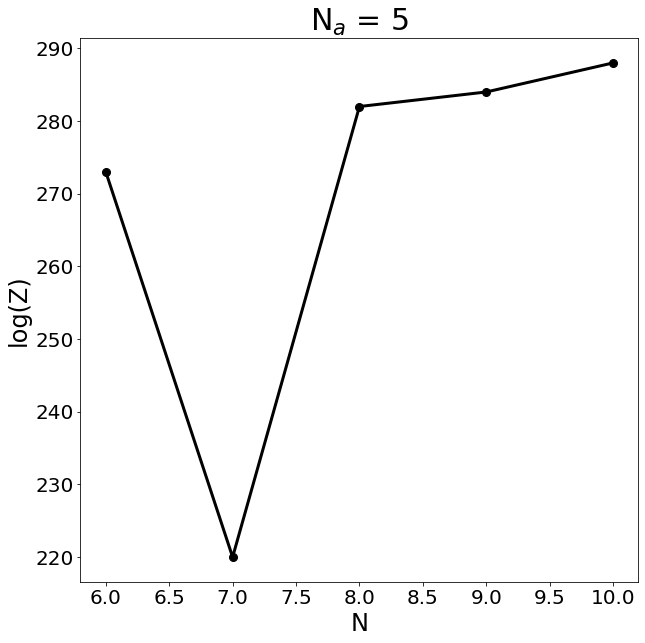

[[1.05001073 1.23278541 1.05000072 1.19493161 1.24997883]
 [1.05022041 1.18792986 1.05001182 1.24998695 1.24989826]
 [1.05048572 1.19670338 1.249846   1.05589663 1.24846957]
 [1.24435622 1.18188071 1.13915693 1.18261167 1.0593865 ]
 [1.05110225 1.13412224 1.19813421 1.15713807 1.24860907]
 [1.08366907 1.17164601 1.16438028 1.17082691 1.064619  ]
 [1.05685954 1.16132394 1.15941303 1.16931762 1.23954974]
 [1.10339494 1.17081932 1.15596583 1.1783212  1.07465596]
 [1.07965673 1.15858715 1.15996916 1.17298127 1.20479092]
 [1.09793474 1.16505816 1.15946783 1.17646659 1.1102726 ]]


In [175]:
path2files = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity'
base_dir_name = 'BOTHAXES_150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_5_60MinObs_SpectralComplexity_N'
N_dirs = 10

read.read_horizontal(path2files, base_dir_name, N_dirs)

In [142]:
A = 'BOTHAXES_150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_5_60MinObs_SpectralComplexity_N1'
where = A.find('Nscafac_')

print(where + len('Nscafac_') + 1 )

87


# Along Vertical Axes

['150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_1_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_2_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_3_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_4_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_5_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_6_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_7_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_8_60MinObs_SpectralComplexity_N1', '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_9_60MinO

<ipython-input-120-82c0e0c25fc5>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scale_factors = np.array(scale_factors)


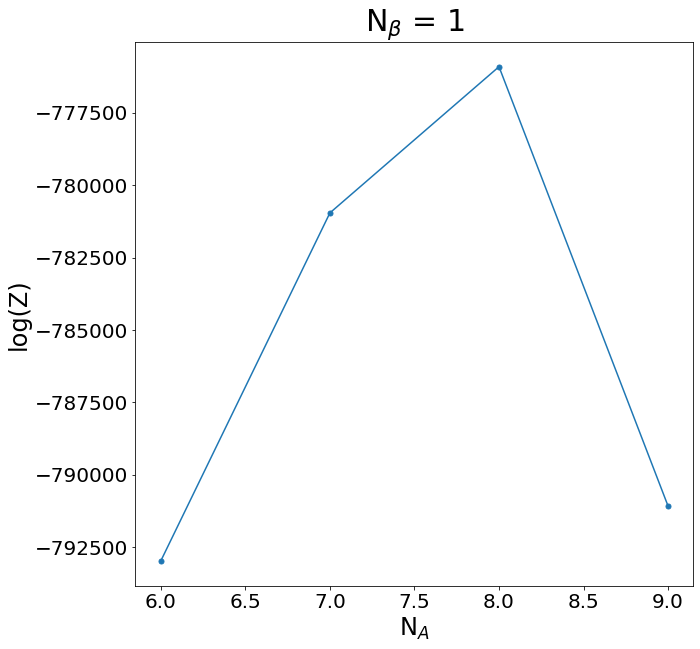

In [120]:
#where to look for files 
path2files = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/AlongScafacAxis'
base_dir_name_1 = '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_'
base_dir_name_2 = '_60MinObs_SpectralComplexity_N1'

#how many directories do we need to run the loop for?
N_range = np.arange(9) + 1

#initialize arrays to store the relevant information
logZs = np.zeros_like(N_range)
scale_factors = []
betas  = []

base_dir_name = [base_dir_name_1 +  str(total) + base_dir_name_2 for counter, total in enumerate(N_range)  ]

print(base_dir_name)


for ctr, scafac_total in enumerate(N_range):
    f = open(os.path.join(path2files,base_dir_name[ctr] , 'test.stats'), 'r') 
    lines = f.read()
    
    #this needs to be changed every time we do this :(  
    beta_total = int(base_dir_name[ctr][-1])
    print("BETA " , beta_total)
    

    r = lines.find('log(Z)       =')
    #print(lines[r+15:r + 39])
    logZs[ctr]  = float(lines[r+15:r + 40])
    
    scafacs = []
    sis = []
    #i = 0 corresponds to 1 dim
    print('-----------------------------Read in Betas and Scafacs -------------------------------------------------')
    for ctr_j , beta in enumerate(np.arange(beta_total) + 1):
        #which dim in test.stats are we reading?
        digit = str(beta).strip(".0")        
        r = lines.find(digit + '  0.')
        #print('file ', os.path.join(path2files,base_dir_name[ctr]),  'dim ' , float(lines[r + 3:r + 26]))
        sis.append(float(lines[r+ 3:r + 26]))
    betas.append(sis)
    
    #Read in scale factors, if any
    for ctr_i , scafac in enumerate(np.arange(scafac_total ) + beta_total + 1):
        #which dim in test.stats are we reading?
        digit = str(scafac).strip(".0")  
        #the digit 10 gets screwed up for some reason
        if scafac == 10:
            digit = '10'
            print('Find a better way to do this please')
        r = lines.find(digit + '  0.')
        scafacs.append(float(lines[r+ 3:r + 26]))
    scale_factors.append(scafacs)
    
    
        
        
    f.close()
    

betas = np.array(betas)  
scale_factors = np.array(scale_factors)


plt.figure(figsize = (10,10))
plt.ylabel(r'log(Z)', fontsize = 24)
plt.xlabel(r'N$_A$', fontsize = 24)
plt.title(r'N$_\beta$ = ' + str(beta_total), fontsize = 30 )
plt.plot(N_range[5:],logZs[5:], marker = 'o', markersize = 5)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()



In [190]:
path2files = path2files + '/TestFolderwAll2DGrid'
print(path2files)

/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/TestFolderwAll2DGrid


150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_1_60MinObs_SpectralComplexity_N2
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Sc

/Users/michael/Research/REACH/scale_factor_Nreg/Debug_stuff/read_in_posterior_info.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  betas = np.array(betas)


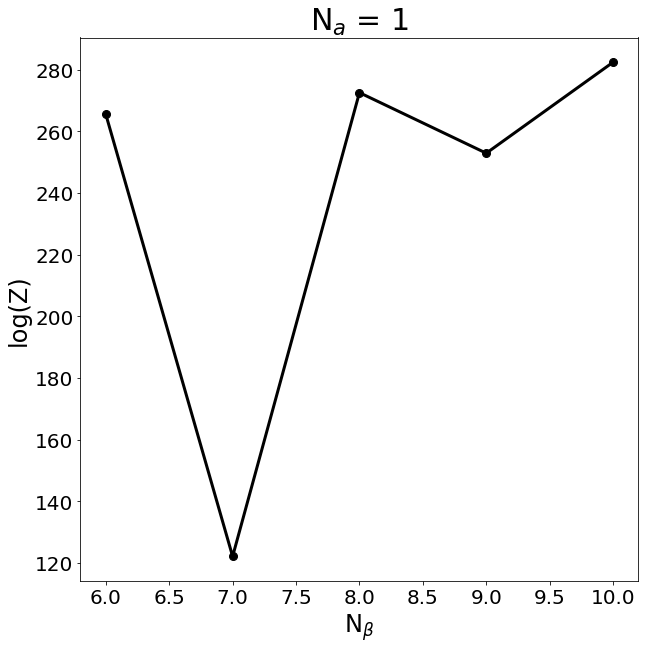

[[1.15912536]
 [1.16514165]
 [1.16461567]
 [1.16471838]
 [1.16531688]
 [1.16465275]
 [1.16507617]
 [1.16483678]
 [1.16480161]
 [1.1646731 ]]
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-----------------------------Read in Betas and Scafacs -------------------------------------------------
-------------------

/Users/michael/Research/REACH/scale_factor_Nreg/Debug_stuff/read_in_posterior_info.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.betas = np.array(self.betas)


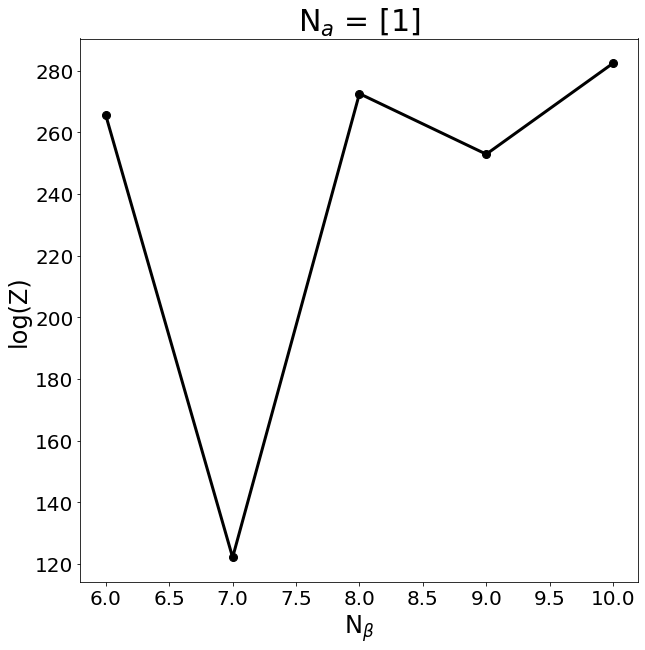

In [221]:
_1 = '150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_'
_2 = '_60MinObs_SpectralComplexity_N'

def base_dir_name(base_dir_name_chunks, a, b):
        return base_dir_name_chunks[0] + str(a) + base_dir_name_chunks[1] + str(b)
    
    
print(base_dir_name([_1, _2] , 1, 2))


read.read_BOTH(path2files, [_1, _2], 1, 10)


reader_obj = read.read_in(path2files, [_1, _2], 1, 10)



reader_obj.plot_along_one_direction(scafac = 1)

# Grid 

In [405]:
base_path = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/Grid/Grid'

chunk1 = 'BOTHAXES_150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_'
chunk2 = '_60MinObs_SpectralComplexity_N'

read.read_in.info()


reader_obj = read.read_in(base_path, [chunk1, chunk2], 9, 9, include_zero_scafac = True)






#not monotonic in either direction
#on average gets better though


Chunk file names are the directory name split into two (N_reg and N_scafac). For example, the directory 150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_10_60MinObs_SpectralComplexity_N10 would be split into :  150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_ _2 = _60MinObs_SpectralComplexity_N
(900, 840, 3)
scafac_dir beta_dir  0 1 3.08384771623379 4.22818657358825e-05 3.12292798284151 False
(900, 840, 3)
scafac_dir beta_dir  1 1 9.9999895514193 1.06255480426924e-05 9.47602719179745 False
(900, 840, 3)
scafac_dir beta_dir  2 1 9.99998891245152 1.08966467255384e-05 9.4562229099096 False
(900, 840, 3)
scafac_dir beta_dir  3 1 9.99998953594661 1.02214387237172e-05 9.43077760713054 False
(900, 840, 3)
scafac_dir beta_dir  4 1 9.99998888842581 1.08284686358836e-05 9.06123229247346 False
(900, 840, 3)
scafac_dir beta_dir  5 1 9.99998859754951 1.177726669462e-05 9.69540344823735 False
(900, 840, 3)
scafac_dir beta_dir  6 1 9.99998760

(900, 840, 3)
scafac_dir beta_dir  1 9 0.0561463373455631 0.0117726890517137 47.6042093067809 False
(900, 840, 3)
scafac_dir beta_dir  2 9 0.0356928295483451 0.0322651808651289 41.5924771195128 True
(900, 840, 3)
scafac_dir beta_dir  3 9 0.153315491640506 0.135512431904065 23.6760612923647 False
(900, 840, 3)
scafac_dir beta_dir  4 9 0.292452329414896 0.109814769664421 8.8643839316565 False
(900, 840, 3)
scafac_dir beta_dir  5 9 0.024262804496227 0.0166798258110465 38.0589342620524 True
(900, 840, 3)
scafac_dir beta_dir  6 9 0.044967471008391 0.0535272971245612 29.1887162837471 True
(900, 840, 3)
scafac_dir beta_dir  7 9 0.320062953140374 0.0936312968624197 7.2654887856773 False
(900, 840, 3)
scafac_dir beta_dir  8 9 0.0113907791780257 0.0105819109652264 25.5323693345027 True
(900, 840, 3)
scafac_dir beta_dir  9 9 0.0192598971601472 0.0162125251903204 24.3793558074946 True


/Users/michael/Research/REACH/scale_factor_Nreg/Debug_stuff/read_in_posterior_info.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.betas = np.array(self.betas)
/Users/michael/Research/REACH/scale_factor_Nreg/Debug_stuff/read_in_posterior_info.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.scale_factors = np.array(self.scale_factors)


True


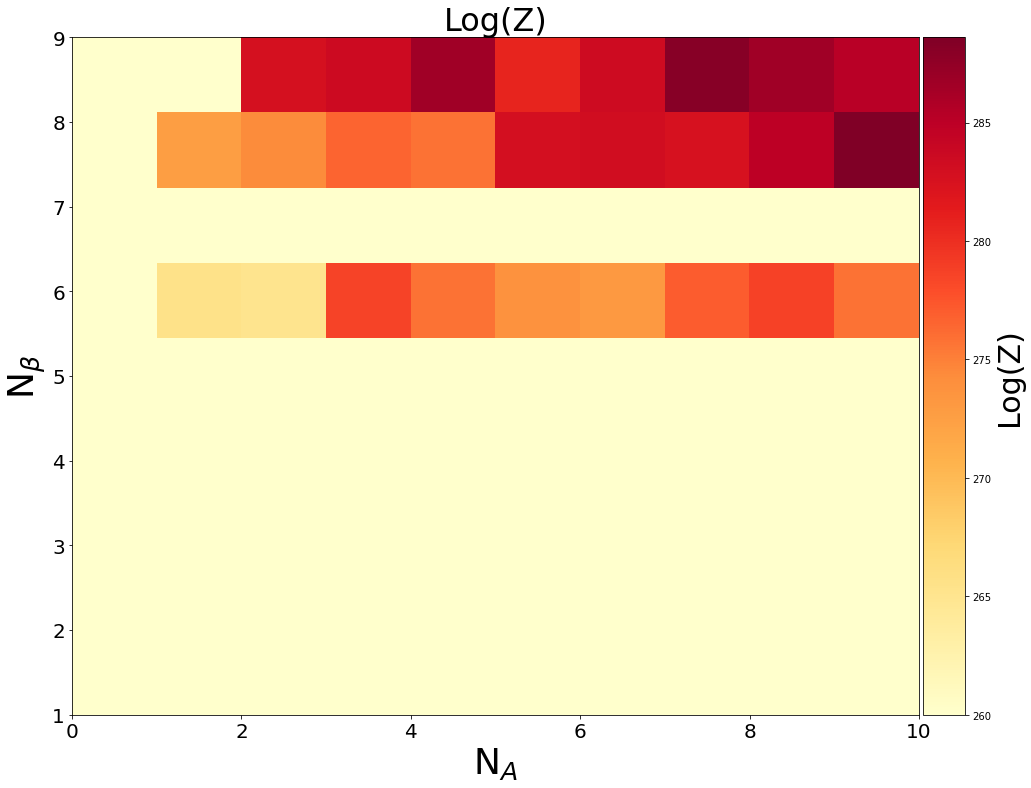

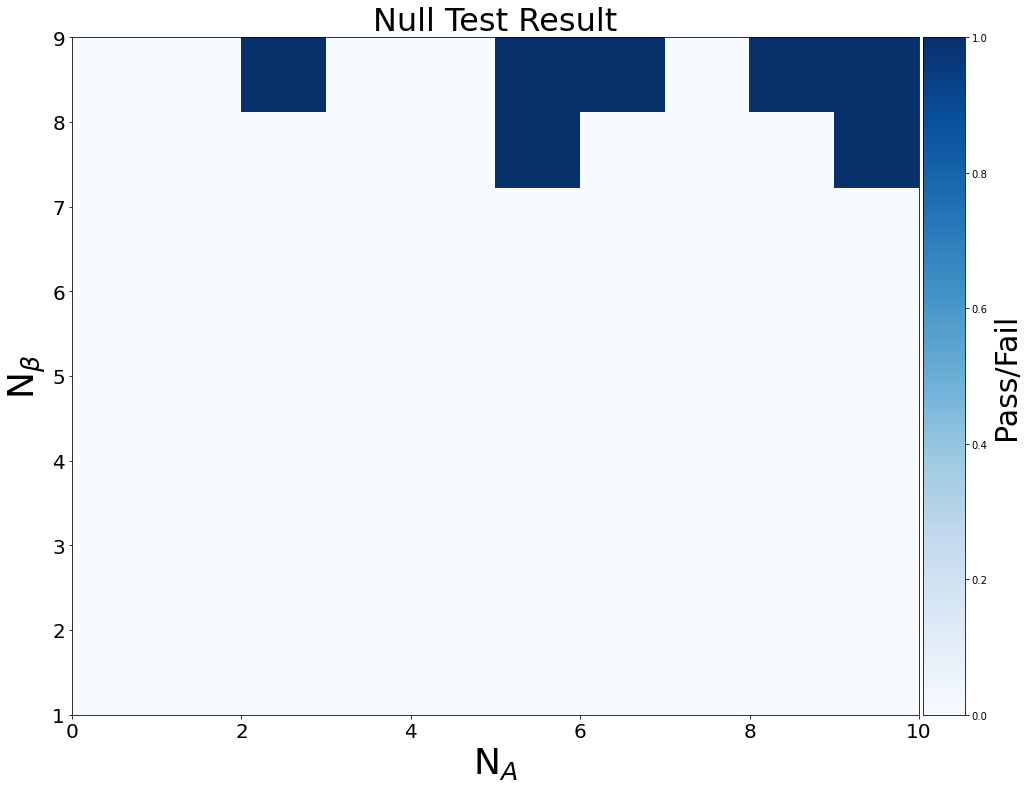

In [414]:
reader_obj.plot_grid(saturation_lower_limit = 260, saturation_upper_limit = None, color_scheme = 'YlOrRd')


reader_obj.pass_fail_grid()





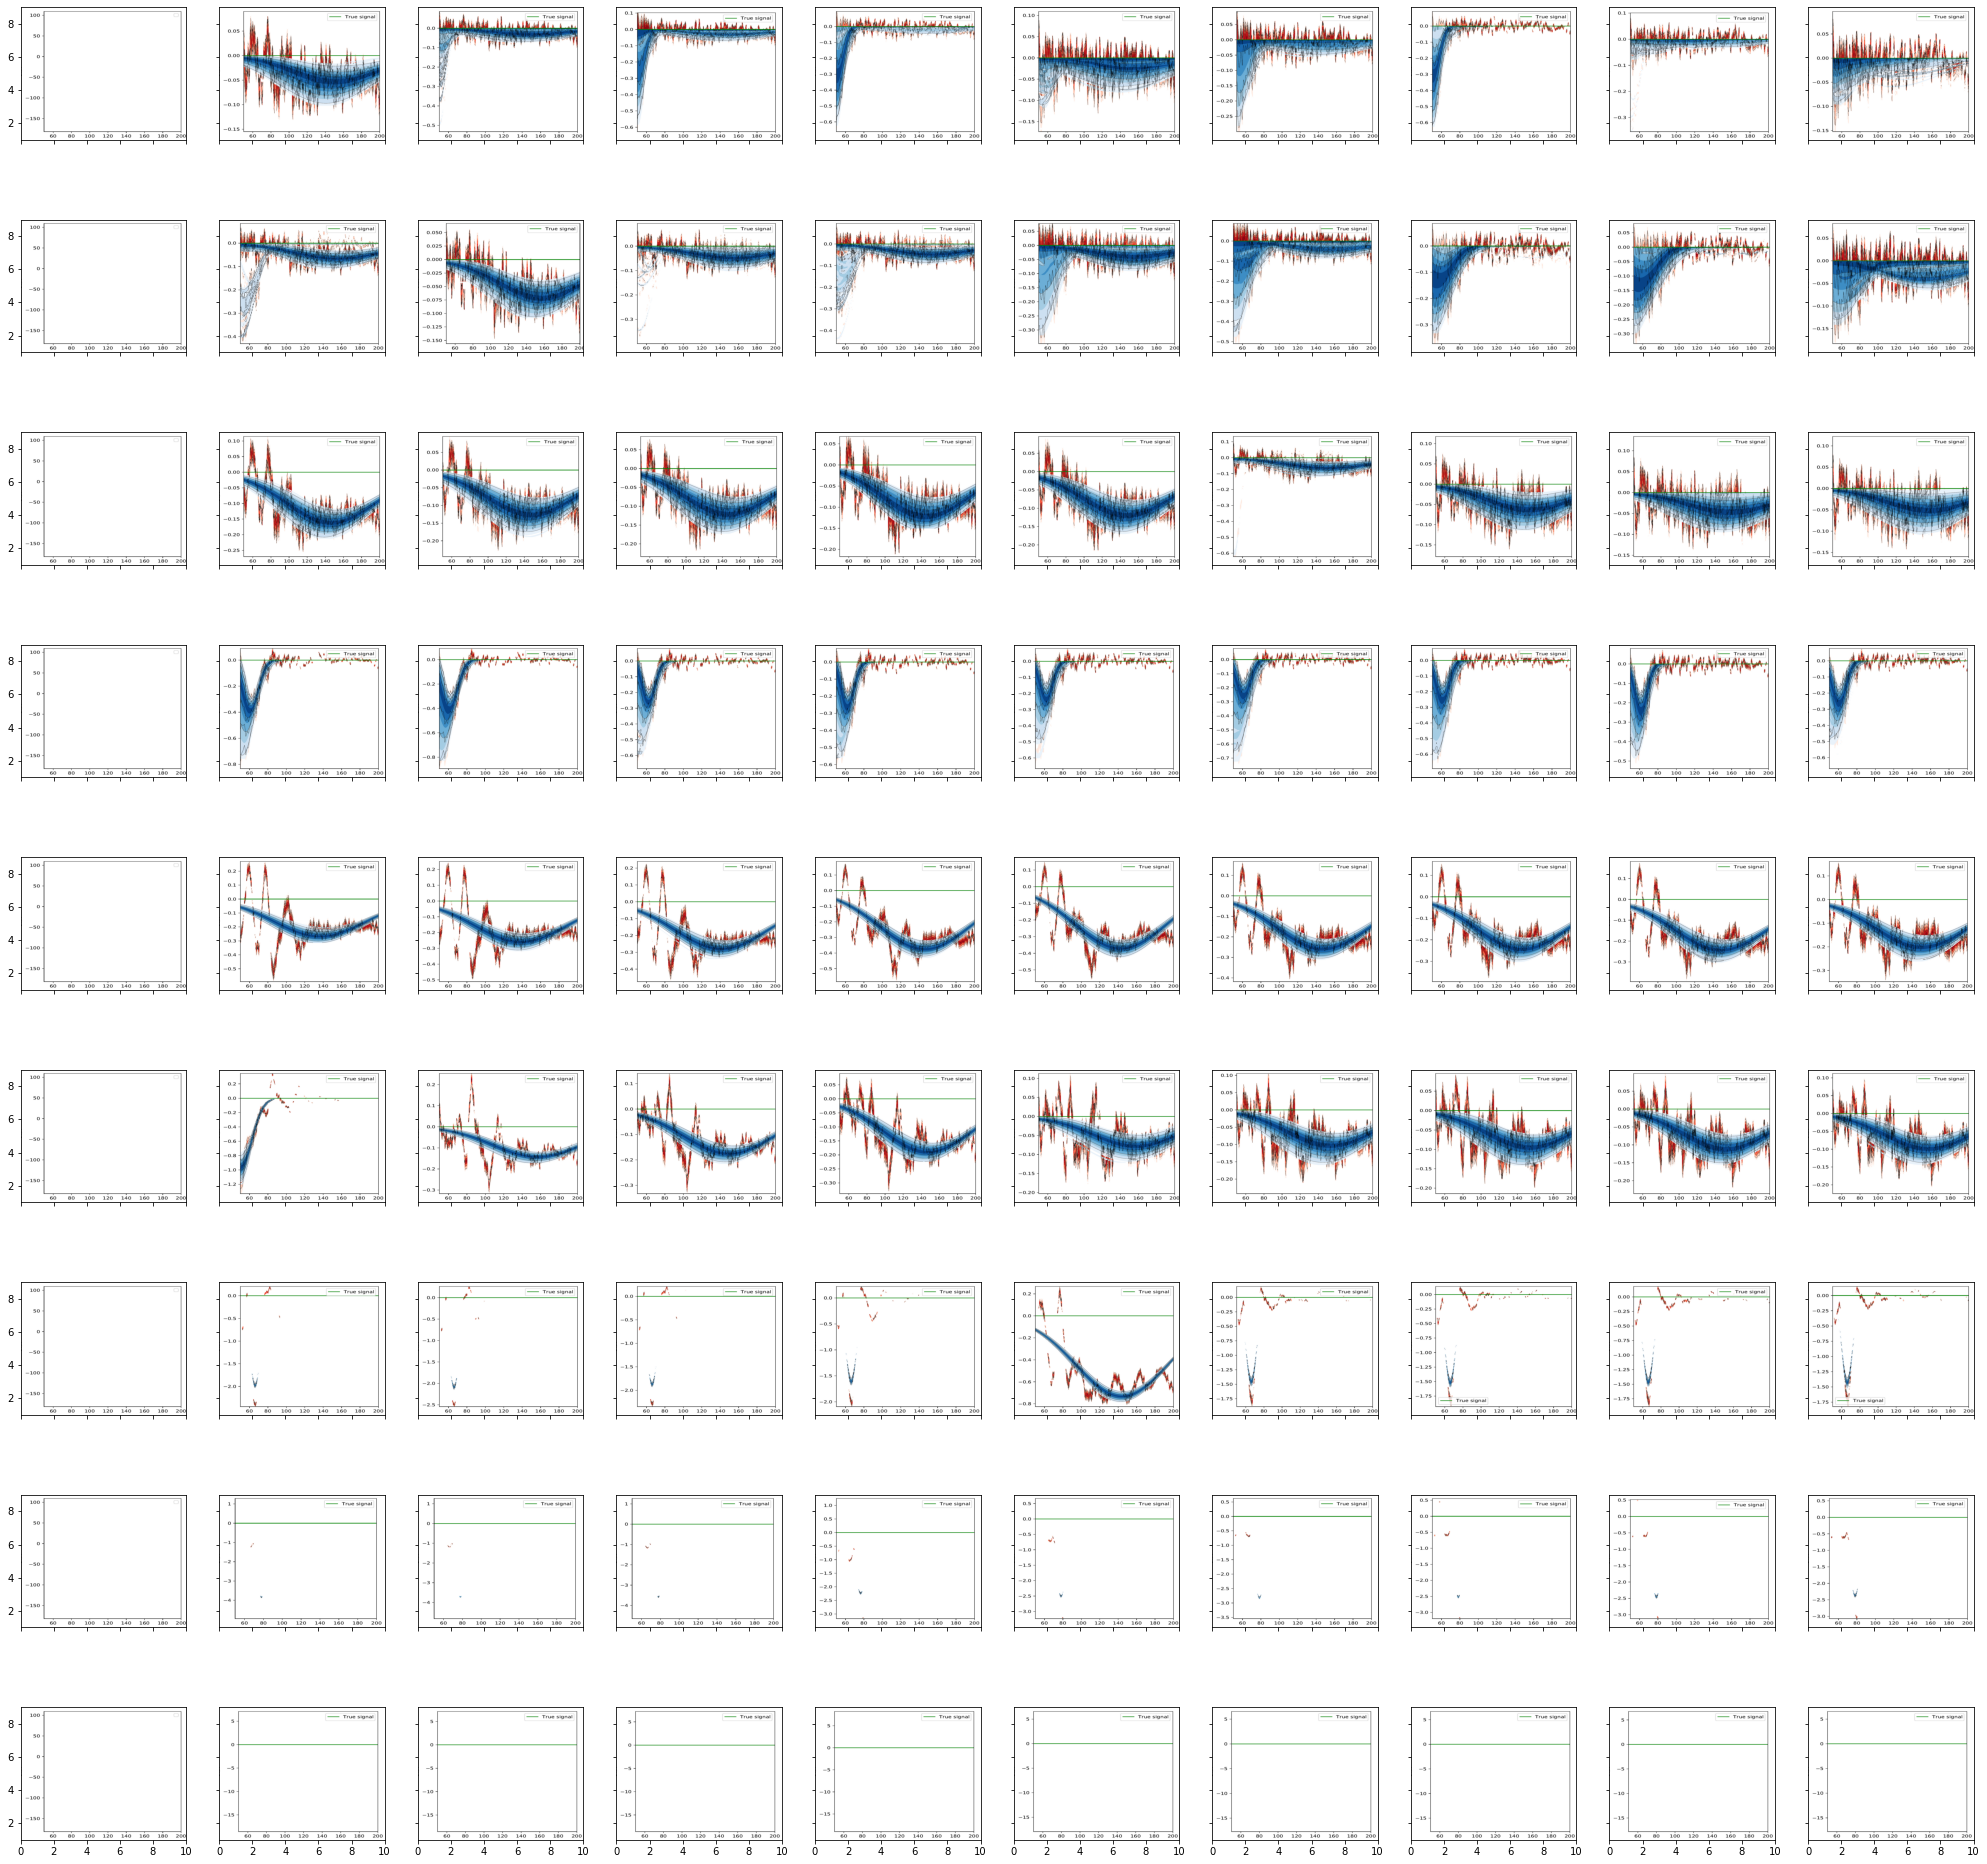

In [410]:
reader_obj.image_grid()

In [406]:
A = (True, False)

np.array(A).astype(int)

A = np.arange(9)
print(A.shape)

(9,)


(960, 1280, 3)
(900, 840, 3)


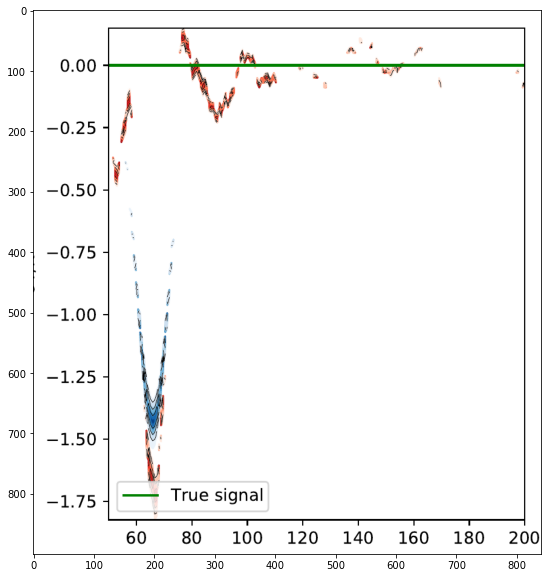

In [359]:
from PIL import Image
lala = '/Volumes/Tubster/REACH/150MHz/AngPSpec150MHz_Errors/RayleighJeans/ThoroughReRunWithDiffPriorMaps/TightPriorsOnAmps/SpectralComplexity/Grid/Grid/BOTHAXES_150MHzAbsErrsRayleighJeansDrawPspecFractionalErrsScaled_fitwAllSky150_Nscafac_9_60MinObs_SpectralComplexity_N3/'
Array = np.asarray(Image.open(lala + '335cbc1f-2565-4063-b44b-d4364249f105-1.ppm'))
print(Array.shape)
print(Array[0:-60,50:-390].shape)
plt.figure(figsize = (10,10))
plt.imshow(Array[0:-60,50:-390])
plt.show()
plt.close()
    
    
    

In [394]:
reader_obj.logZs.shape

np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# log(Z) errors for non spectrally-complex case (wide prior ranges) 